Petidarat Vagost 66070504011

**Part 1: Data Loading & Initial Inspection**

In [1]:
#Import the used library
import pandas as pd
import matplotlib.pyplot as plt

#Upload dataframe into pandas with error annoucement if not found
try:
    df = pd.read_csv('dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("Error: 'dataset.csv' not found.")
except Exception as e:
    raise Exception(f"An error occurred while loading the dataset: {e}")

Dataset loaded successfully.


In [2]:
#Get an insight of data characteristic
print("\nDescribing Data Set..\n")
print(df.describe())

print("\nDisplaying Information of this Data Set..\n")
print(df.info())

print("\nShowing First 10 Rows of Data Set..\n")
print(df.head(10))


Describing Data Set..

       Transaction ID   Item Quantity Price Per Unit Total Spent  \
count           10000   9667     9862           9821        9827   
unique          10000     10        7              8          19   
top       TXN_9226047  Juice        5              3           6   
freq                1   1171     2013           2429         979   

        Payment Method  Location Transaction Date  
count             7421      6735            10000  
unique               5         4              733  
top     Digital Wallet  Takeaway          UNKNOWN  
freq              2291      3022              159  

Displaying Information of this Data Set..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   o

**Data Quality Issues**
1. *The data is not in the suitable type.* For example, elements in "Transaction Date" are object, while date is more suitable. The numerical data such as "Quantity", "Price Per Unit", and so on is neither float nor integer.
2. *Missing values in most columns.* There are 10K rows in total and every column, excluding "Transaction ID" and "Transaction Date", is not consisted of 10K elements.
3. *Some row might be filled up, but data is either irrelevant or unknown.* For instance, there is "ERROR" in "Total Spent" column and there is "UNKNOWN" in "Item", "Location", "Payment Method", etc. Essentially, those block do not remain null.


**Part 2: Data Cleaning**

In [3]:
#Change 'Transaction Date' into date format, invalid date will be convert to NaT
df['Transaction Date'] = pd.to_datetime(
    df['Transaction Date'], errors='coerce', dayfirst=True
)
#Count dates format and others frequency. Then, print.
valid_dates = df['Transaction Date'].notna().sum()
invalid_dates = df['Transaction Date'].isna().sum()
print("\nDate Format Evaluation")
print(f"\nValid date rows   : {valid_dates}")
print(f"Invalid date rows : {invalid_dates}")

#Drop unnecessary columns
df = df.drop(['Location', 'Transaction ID'], axis=1)

#Rename columns' name
df = df.rename( columns= { 'Price Per Unit' : 'Price Per Unit ($)',
                          'Total Spent' : 'Total Spent ($)',
})

#Upload the price of each item
price_map = {
    "Coffee": 2,
    "Tea": 1.5,
    "Sandwich": 4,
    "Salad": 5,
    "Cake": 3,
    "Cookie": 1,
    "Smoothie": 4,
    "Juice": 3
}

#Find every element of this column, and choose the irrelevant data to remove
print("\nIrrelevant Data Evaluation\n")
frequency = df['Item'].value_counts()
print(frequency)

#Drop Row with null, UNKNOWN, and ERROR in 'Item'
df = df.dropna(subset=['Item']) 
df = df[~df['Item'].str.contains('UNKNOWN|ERROR', case=False, na=False)]

#Convert Price into right value directly in existing column
def get_price(item):
    for keyword, price in price_map.items():
        if pd.notna(item) and keyword.lower() in str(item).lower():
            return int(price) 
    return None 
df['Price Per Unit ($)'] = df['Item'].apply(get_price)

#Count frequency of each payment method. Then, find the method that should be filled in invalid data
print("\nFrequency Before Modification\n")
frequency = df['Payment Method'].value_counts()
print(frequency)

#Replace null, 'UNKNOWN', and 'ERROR' with Digital Walllet in 'Payment Method'
df.loc[
    df['Payment Method'].isna() |
    df['Payment Method'].str.contains('UNKNOWN|ERROR', case=False, na=False),
    'Payment Method'
] = 'Digital Wallet'

#Change invalid values to 0 then convert the column to integer. Drop the row that gets value = 0
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0).astype(int)
df = df[df['Quantity'] != 0]


#Reset the index number of the dataframe
df = df.reset_index(drop=True)


Date Format Evaluation

Valid date rows   : 7187
Invalid date rows : 2813

Irrelevant Data Evaluation

Item
Juice       1171
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
UNKNOWN      344
ERROR        292
Name: count, dtype: int64

Frequency Before Modification

Payment Method
Digital Wallet    2065
Cash              2046
Credit Card       2043
ERROR              286
UNKNOWN            261
Name: count, dtype: int64


In [4]:
#Check the data after cleaning
print("\nDescribing Data Set..\n")
print(df.describe)

print("\nDisplaying Information of this Data Set..\n")
print(df.info())

print("\nShowing First 10 Rows of Data Set..\n")
print(df.head(10))


Describing Data Set..

<bound method NDFrame.describe of           Item  Quantity  Price Per Unit ($) Total Spent ($)  Payment Method  \
0       Coffee         2                   2               4     Credit Card   
1         Cake         4                   3              12            Cash   
2       Cookie         4                   1           ERROR     Credit Card   
3        Salad         2                   5              10  Digital Wallet   
4       Coffee         2                   2               4  Digital Wallet   
...        ...       ...                 ...             ...             ...   
8606  Smoothie         2                   4             NaN            Cash   
8607    Coffee         2                   2               4  Digital Wallet   
8608    Coffee         4                   2               8  Digital Wallet   
8609    Cookie         3                   1               3  Digital Wallet   
8610  Sandwich         3                   4              12  

**Step Summary:**
1.  I converted 'Transaction Date' into date format, and filled NaT into invalid date data.I did not drop any invalid rows because invalide dates are nearly 28% of the original dataframe.
2. I dropped the 'Location' and 'Transaction ID' column because it does not meet expectation of questions in Part 4.
3. I renamed some column by adding ($) at the columns that are financial related.
4. I dropped the rows with null or invalid data  in 'Item' column because it is impossible to estiimate it. Moreover, the quantity of the dropped rows are still acceptable.
5. I created a price_map to match the actual price with the right item. Then, plug it in the 'Price Per Unit ($)' directly by replacing the new values.
6. I found the frequency of elements in 'Payment Method', and I replaced invalide values with the most frequent element.
7. I filled 0 into the rows with invalid data in 'Quantity', and converted all values into integer. I decided to replace with 0 and drop rows because I would like the data to be accurate as much as possible by not using mean or median.
8. Eventuallly, I reset the index number of the dataframe.

**Part 3: Feature Engineering (Creating New Insight)**

In [5]:
#Create a new column of 'Total_Sale'
df['Total_Sale ($)'] = df['Quantity'] * df['Price Per Unit ($)']

#Create columns from 'Transaction Date' into day and month
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df['Day_of_Week'] = df['Transaction Date'].dt.day_name()
df['Month'] = df['Transaction Date'].dt.month_name()

#Check the data
print("\nDescribing Data Set..\n")
print(df.describe)

#Save the new dataframe into PC as CSV
df.to_csv("cleaned_dataset.csv", index=False)
print("\nThe cleaned_dataset.csv is saved in the same folder!")


Describing Data Set..

<bound method NDFrame.describe of           Item  Quantity  Price Per Unit ($) Total Spent ($)  Payment Method  \
0       Coffee         2                   2               4     Credit Card   
1         Cake         4                   3              12            Cash   
2       Cookie         4                   1           ERROR     Credit Card   
3        Salad         2                   5              10  Digital Wallet   
4       Coffee         2                   2               4  Digital Wallet   
...        ...       ...                 ...             ...             ...   
8606  Smoothie         2                   4             NaN            Cash   
8607    Coffee         2                   2               4  Digital Wallet   
8608    Coffee         4                   2               8  Digital Wallet   
8609    Cookie         3                   1               3  Digital Wallet   
8610  Sandwich         3                   4              12  

**Step Summary:**
1. I created a new column called 'Total_Sale', which is a multiplication of 'Quantity' and 'Price Per Unit'. This column ensures that the values of total sale is accurate. 
Ps. I could not write the correct name of the columns it gave me the weird texts. There is ($) at the end of financial related columns.
2.  I created 2 more columns directly from 'Transaction Date', which were converted to 'Month' and 'Day_of_Week'..

**Part 4: EDA**

1. Top 5 Best Selling Items

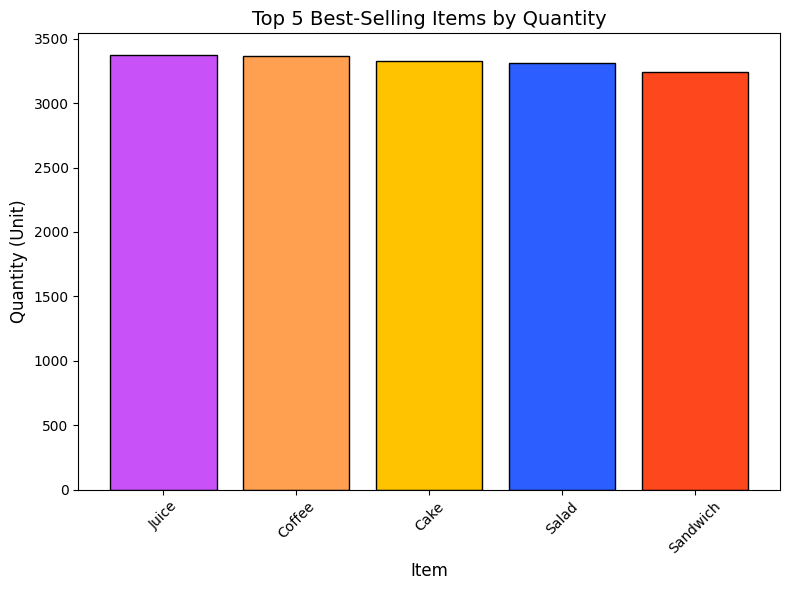

Plot saved as 'Top 5 Best Quantity Sale.png'


In [ ]:
#Considering by total quantity sale in unit
#Group by Item and sum the sales
top_items = df.groupby('Item')['Quantity'].sum().sort_values(ascending=False).head(5)

#Plot the bar graph with custom colors
colors = [ "#C851F7","#FF9F50", '#FFC300', "#2B5DFF","#FF471D"]
plt.figure(figsize=(8, 6))
plt.bar(top_items.index, top_items.values, color=colors, edgecolor='black')
plt.title('Top 5 Best-Selling Items by Quantity', fontsize=14)
plt.xlabel('Item', fontsize=12)
plt.ylabel('Quantity (Unit)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

#Save the plot as PNG
plt.savefig("Top_5_Best_Quantity_Sale.png", dpi=300)
plt.show()
print("Plot saved as 'Top 5 Best Quantity Sale.png'")

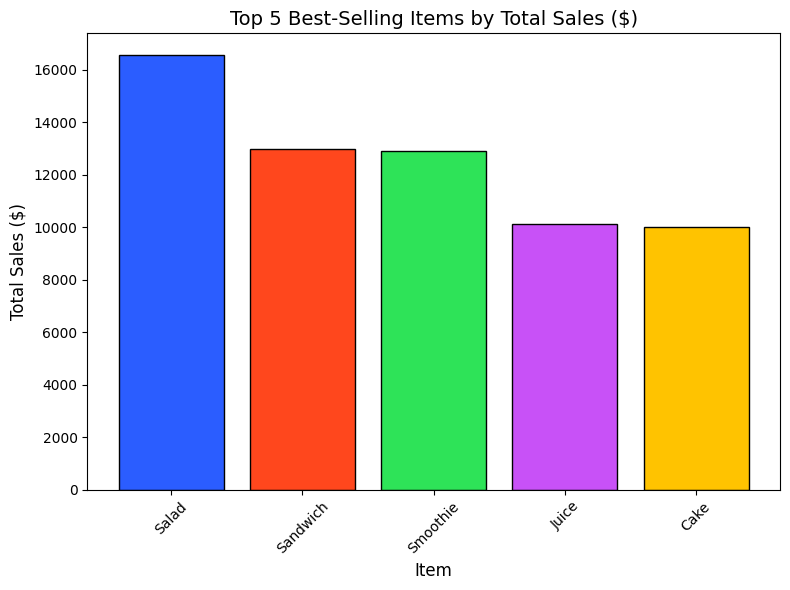

Plot saved as 'Top 5 Best Sale($).png'


In [7]:
#Considering by total sale in USD

#Group by Item and sum the sales
top_items = df.groupby('Item')['Total_Sale ($)'].sum().sort_values(ascending=False).head(5)

#Plot the bar graph with custom colors
colors = [ "#2B5DFF","#FF471D", "#2EE358", "#C851F7", '#FFC300']
plt.figure(figsize=(8, 6))
plt.bar(top_items.index, top_items.values, color=colors, edgecolor='black')
plt.title('Top 5 Best-Selling Items by Total Sales ($)', fontsize=14)
plt.xlabel('Item', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

#Save the plot as PNG
plt.savefig("Top_5_Best_Sale($).png", dpi=300)
plt.show()
print("Plot saved as 'Top 5 Best Sale($).png'")

2. Peak Sales Day

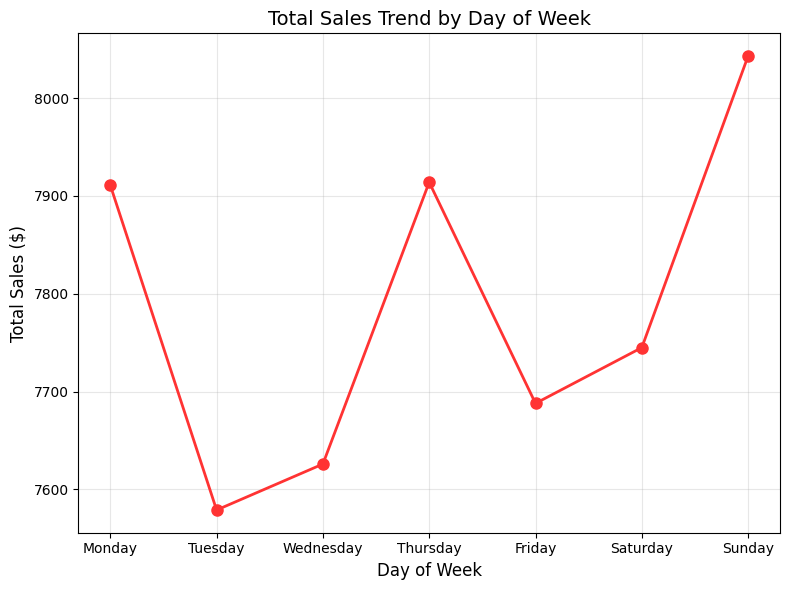

Line chart saved as 'Peak_Sale_Day.png'


In [8]:
#Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Group data by Day_of_Week and sum total sales
day_sales = df.groupby('Day_of_Week')['Total_Sale ($)'].sum()

#Reindex to follow weekday order
day_sales = day_sales.reindex(weekday_order)

#Plot line chart
plt.figure(figsize=(8, 6))
plt.plot(day_sales.index, day_sales.values, marker='o', linestyle='-', color="#FF3333", linewidth=2, markersize=8)
plt.title('Total Sales Trend by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

#Save as PNG
plt.savefig("Peak_Sale_Day.png", dpi=300)
plt.show()
print("Line chart saved as 'Peak_Sale_Day.png'")

3. Monthly Sale Trend

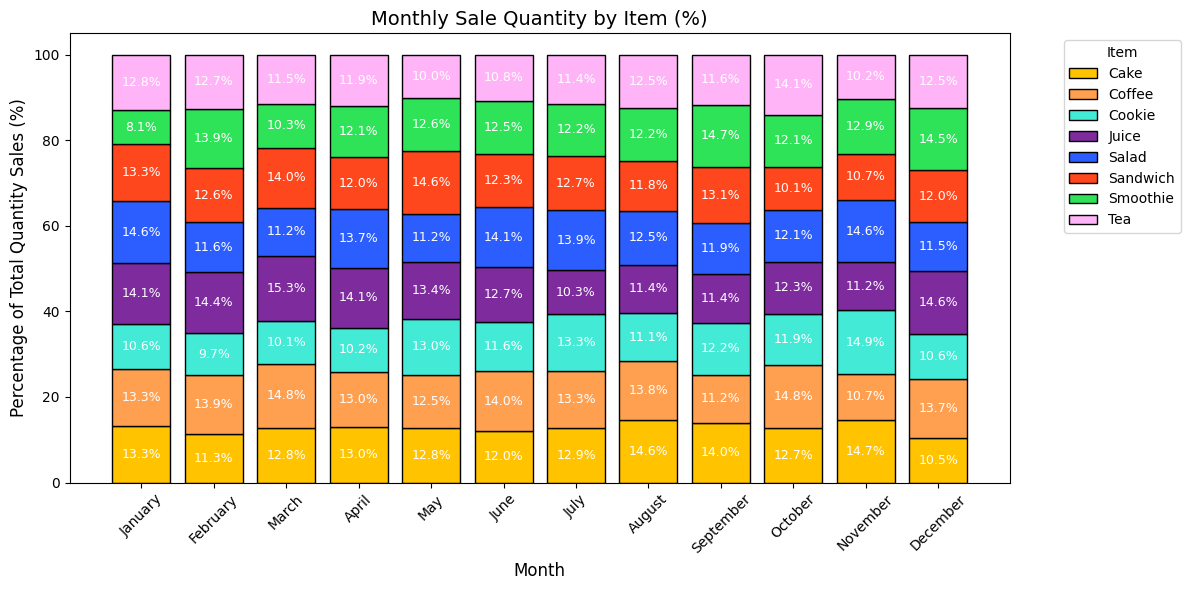

Saved as 'Monthly_Sales_Quantity_Percentage.png'


In [ ]:
#Considering by Total Sale in Quantity Unit Percentage

#Group by Month and sum sales
monthly_sales = df.groupby('Month')['Quantity'].sum()

#Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.reindex(month_order).fillna(0)
#Group by Month and Item for quantity
monthly_item_sales = df.groupby(['Month','Item'])['Quantity'].sum().unstack(fill_value=0)
monthly_item_sales = monthly_item_sales.reindex(month_order)

#Convert values to percentage
monthly_item_sales_percent = monthly_item_sales.div(monthly_item_sales.sum(axis=1), axis=0) * 100

#Define colors
colors = ['#FFC300', "#FF9F50", "#43EAD6", "#7D2B9D", "#2B5DFF", "#FF471D", "#2EE358", "#FFB4F7"]

#Create plot
fig, ax = plt.subplots(figsize=(12, 6))
bottom = [0] * len(monthly_item_sales_percent)

#Plot bars with labels
for idx, item in enumerate(monthly_item_sales_percent.columns):
    values = monthly_item_sales_percent[item]
    bars = ax.bar(monthly_item_sales_percent.index, values, bottom=bottom,
                  color=colors[idx], edgecolor='black', label=item)
    
    #Add percentage labels on each bar section
    for bar, value in zip(bars, values):
        if value > 3:  #Show labels only if >3% to reduce clutter
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f"{value:.1f}%",
                ha='center', va='center', fontsize=9, color='white'
            )
    
    bottom = [i + j for i, j in zip(bottom, values)]

#Customize chart
ax.set_title('Monthly Sale Quantity by Item (%)', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Percentage of Total Quantity Sales (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#Save PNG
plt.savefig("Monthly_Sales_Quantity_Percentage.png", dpi=300)
plt.show()

print("Saved as 'Monthly_Sales_Quantity_Percentage.png'")


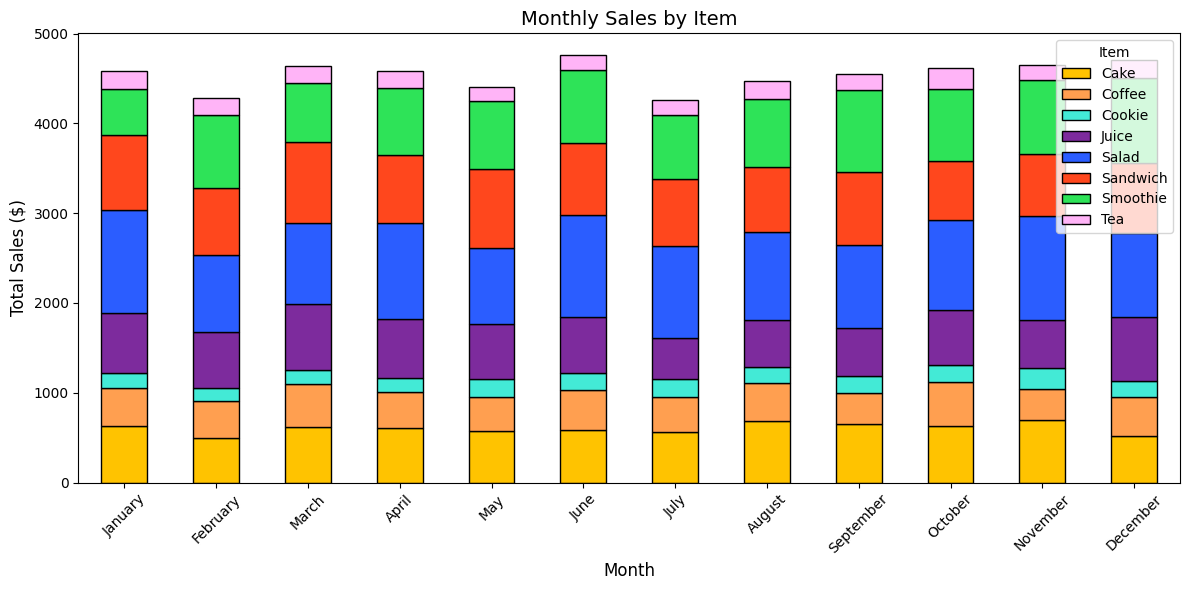

Saved as 'Monthly_Sales_($).png' 


In [10]:
#Considering by Total Sale in USD

#Group by Month and sum sales
monthly_sales = df.groupby('Month')['Total_Sale ($)'].sum()

#Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.reindex(month_order).fillna(0)
#Group by Month and Item
monthly_item_sales = df.groupby(['Month','Item'])['Total_Sale ($)'].sum().unstack(fill_value=0)
monthly_item_sales = monthly_item_sales.reindex(month_order)

#Define custom colors (one for each item)
colors = ['#FFC300',"#FF9F50", "#43EAD6", "#7D2B9D","#2B5DFF", "#FF471D", "#2EE358","#FFB4F7"]

#Plot stacked bar chart
monthly_item_sales.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    edgecolor='black',
    color=colors[:monthly_item_sales.shape[1]])
plt.title('Monthly Sales by Item', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Monthly_Sales_($).png", dpi=300)
plt.show()
print("Saved as 'Monthly_Sales_($).png' ")


4. Popular Payment Method

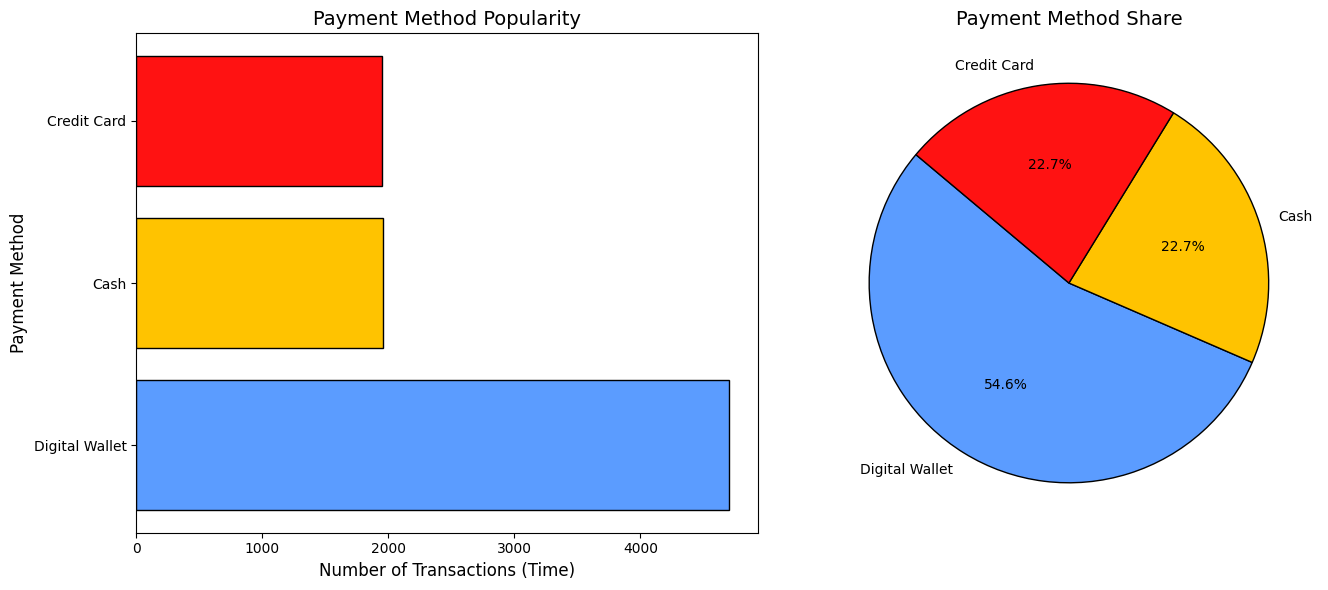

Combined plot saved as 'Payment_Method_Charts.png'


In [11]:
#Count frequency of payment methods
payment_counts = df['Payment Method'].value_counts()

#Custom color palette
colors = ["#5B9CFF", '#FFC300', "#FF1212"]

#Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Horizontal Bar Chart
axes[0].barh(payment_counts.index, payment_counts.values,
             color=colors[:len(payment_counts)], edgecolor='black')
axes[0].set_title('Payment Method Popularity', fontsize=14)
axes[0].set_xlabel('Number of Transactions (Time)', fontsize=12)
axes[0].set_ylabel('Payment Method', fontsize=12)

#Pie Chart
axes[1].pie(payment_counts.values,
            labels=payment_counts.index,
            autopct='%1.1f%%',
            colors=colors[:len(payment_counts)],
            startangle=140,
            wedgeprops={'edgecolor':'black'})
axes[1].set_title('Payment Method Share', fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

#Save combined figure as PNG
plt.savefig("Payment_Method_Charts.png", dpi=300)
plt.show()
print("Combined plot saved as 'Payment_Method_Charts.png'")
